In [ ]:
import pandas as pd
import numpy as np
import io
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression as sk_LogisticRegression
from sklearn import metrics 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from google.colab import files
import os
from sklearn.datasets import load_svmlight_file

# **Task 1: Data Preprocessing**

## **1.1 IMDB Reviews**

In [ ]:
# !curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

--2022-11-08 20:18:38--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  15.1MB/s    in 14s     

2022-11-08 20:18:52 (5.88 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
train_path = "aclImdb/train"
test_path = "aclImdb/test"

print("====================Train Set====================")
print(f"positive reviews: {len(os.listdir(train_path+'/pos'))}")
print(f"negative reviews: {len(os.listdir(train_path+'/neg'))}")

print("====================Test Set====================")
print(f"positive reviews: {len(os.listdir(test_path+'/pos'))}")
print(f"negative reviews: {len(os.listdir(test_path+'/neg'))}")

====================Train Set====================
positive reviews: 12500
negative reviews: 12500
====================Test Set====================
positive reviews: 12500
negative reviews: 12500


In [ ]:
label_train = load_svmlight_file(train_path+'/labeledBow.feat')
label_train_x = pd.DataFrame.sparse.from_spmatrix(label_train[0])
label_train_y = label_train[1]

print("====================Train Set====================")
print("X in training set:", label_train_x.shape, " ", "Y in training set:", label_train_y.shape)


label_test = load_svmlight_file(test_path+'/labeledBow.feat')
label_test_x = pd.DataFrame.sparse.from_spmatrix(label_test[0])
label_test_y = label_train[1]

print()
print("====================Test Set====================")
print("X in test set:", label_test_x.shape, " ", "Y in test set:", label_test_y.shape)

====================Train Set====================
X in training set: (25000, 89527)   Y in training set: (25000,)

====================Test Set====================
X in test set: (25000, 89523)   Y in test set: (25000,)


In [ ]:
# Remove features that have proportion less than 0.1 and larger than 0.5
pro_train = (label_train_x >0).mean(0)
label_train_x_clean = label_train_x.iloc[:, np.where(np.logical_and(pro_train>0.01, pro_train<0.5))[0]]
print("X in training set:", label_train_x_clean.shape)

#pro_test = (label_test_x >0).mean(0)
#label_x_test_clean = label_test_x.iloc[:, np.where(np.logical_and(pro_test>0.01, pro_test<0.5))[0]]
#print("X in test set:", label_x_test_clean.shape)


X in training set: (25000, 1734)


In [ ]:
# Binerize the numerical imdb ratings 
def binerize (raw_target):    
        binerize_target = []
        for i in range(len(raw_target)):
            if raw_target[i] >= 7:
                binerize_target.append(1) # Positive
            if raw_target[i] <= 4:
                binerize_target.append(0) # Negative
        return binerize_target

imdb_y_train_bi = binerize(label_train_y)
print("Y in train set:", len(imdb_y_train_bi))

imdb_y_test_bi = binerize(label_test_y)
print("Y in train set:", len(imdb_y_test_bi))

Y in train set: 25000
Y in train set: 25000


In [ ]:
# Standardize the features and target labels
from sklearn.preprocessing import StandardScaler
imdb_x_train_nor = StandardScaler().fit_transform(label_train_x_clean.to_numpy())
imdb_y_train_nor = StandardScaler().fit_transform(np.reshape(imdb_y_train_bi, (-1,1))).flatten()

imdb_x_train_transposed = np.transpose(imdb_x_train_nor)
print(imdb_x_train_nor.shape, imdb_x_train_transposed.shape, imdb_y_train_nor.shape)

# Compute zscore
imdb_zscore = np.matmul(imdb_x_train_transposed, imdb_y_train_nor)/np.sqrt(len(imdb_y_train_nor))

(25000, 1734) (1734, 25000) (25000,)


In [ ]:
# Select top 500 features based on zscore for training set
imdb_top_zscore_index = np.abs(imdb_zscore).argsort(axis=0)[-500:].flatten()
imdb_x_train_top500 = label_train_x.iloc[:, imdb_top_zscore_index]

# Select top 500 features for test set
imdb_x_test_features = label_test_x.iloc[:, imdb_top_zscore_index]
print(imdb_x_test_features.shape)

# Standardize features
imdb_x_train_top500_nor = StandardScaler().fit_transform(imdb_x_train_top500.to_numpy())
imdb_x_test_top500_nor = StandardScaler().fit_transform(imdb_x_test_features.to_numpy())

# imdb_y_test_nor = StandardScaler().fit_transform(np.reshape(imdb_y_test_bi, (-1,1))).flatten()
print()
print(imdb_x_train_top500_nor.shape)
print(imdb_x_test_top500_nor.shape)

(25000, 500)

(25000, 500)
(25000, 500)


In [ ]:
# Select top 1000 features based on zscore for training set
imdb_top_zscore_index_1000 = np.abs(imdb_zscore).argsort(axis=0)[-1000:].flatten()
imdb_x_train_top1000 = label_train_x.iloc[:, imdb_top_zscore_index_1000]


imdb_x_test_top1000 = label_test_x.iloc[:, imdb_top_zscore_index_1000]
print(imdb_x_test_top1000.shape)

# Standardize features
imdb_x_train_top1000_nor = StandardScaler().fit_transform(imdb_x_train_top1000.to_numpy())
imdb_x_test_top1000_nor = StandardScaler().fit_transform(imdb_x_test_top1000.to_numpy())

#imdb_y_test_1000_nor = StandardScaler().fit_transform(np.reshape(imdb_y_test_bi, (-1,1)))
print()
print(imdb_x_train_top1000_nor.shape)
print(imdb_x_test_top1000_nor.shape)

(25000, 1000)

(25000, 1000)
(25000, 1000)


In [ ]:
# Top 500 features without standardization
imdb_top_zscore_index = np.abs(imdb_zscore).argsort(axis=0)[-500:].flatten()
imdb_x_train_top500_without = label_train_x.iloc[:, imdb_top_zscore_index]
print(imdb_x_train_top500_without.shape)

imdb_x_test_top500_without = label_test_x.iloc[:, imdb_top_zscore_index]
print(imdb_x_test_top500_without.shape)


(25000, 500)
(25000, 500)


## **1.2 20-news-groups**

In [ ]:
import random
random.seed(551)

In [ ]:
from sklearn.datasets import fetch_20newsgroups
categories = ['comp.graphics', 'rec.sport.hockey', 'sci.med', 'soc.religion.christian']
data_train = fetch_20newsgroups(
    subset="train",
    categories = categories,
    remove=(['headers', 'footers', 'quotes']))

data_test = fetch_20newsgroups(
    subset="test",
    categories = categories,
    remove=(['headers', 'footers', 'quotes']))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tf_vectorizer = CountVectorizer(max_df=0.5, min_df=0.01)
X_train_tf = tf_vectorizer.fit_transform(data_train.data)
print(X_train_tf.shape)
print(type(X_train_tf))
X_test_tf = tf_vectorizer.transform(data_test.data)

print(X_test_tf.shape)

(2377, 1586)
<class 'scipy.sparse.csr.csr_matrix'>
(1582, 1586)


In [ ]:
ng_train_x = pd.DataFrame.sparse.from_spmatrix(X_train_tf)
ng_train_y = data_train.target
#np.count_nonzero(ng_train_x, axis=0)
print("====================Train Set====================")
print("X in training set:", ng_train_x.shape, " ", "Y in training set:", ng_train_y.shape)

ng_test_x = pd.DataFrame.sparse.from_spmatrix(X_test_tf)
ng_test_y = data_test.target
#print(ng_test_y)

print()
print("====================Test Set====================")
print("X in testing set:", ng_test_x.shape, " ", "Y in testing set:", ng_test_y.shape)

====================Train Set====================
X in training set: (2377, 1586)   Y in training set: (2377,)

====================Test Set====================
X in testing set: (1582, 1586)   Y in testing set: (1582,)


In [ ]:
from sklearn.preprocessing import OneHotEncoder, normalize
one_hot_encoder = OneHotEncoder(sparse=False)
ng_train_y_encoded = one_hot_encoder.fit_transform(X=np.reshape(ng_train_y, (-1,1)))
print(ng_train_y_encoded.shape)

ng_test_y_encoded=one_hot_encoder.fit_transform(X=np.reshape(ng_test_y, (-1,1)))
print(ng_test_y_encoded.shape)

(2377, 4)
(1582, 4)


MI score

In [ ]:
import sklearn.feature_selection
#ng_train_x_clean.columns.values.shape
#sklearn.metrics.mutual_info_score(ng_train_x_clean_T.columns.values, ng_train_y_encoded[...,0])
#sklearn.metrics.mutual_info_score(ng_train_y_encoded[...,0], ng_train_x.values)
x_MI_c1=sklearn.feature_selection.mutual_info_classif(X_train_tf, ng_train_y_encoded[...,0])

#x_MI_c1=sklearn.metrics.mutual_info_score(ng_train_x_clean.columns.values, ng_train_y_encoded[...,0])

In [ ]:
#sort features descending
x_sort_index1=np.argsort(-x_MI_c1)
#select highest 100 features for class1
print(x_sort_index1[:100])

[ 626  655 1533  555  554  677  703   39  615 1094 1507 1285 1409 1020
  944  590  675  319 1544  168 1399  606  577  704  338 1495  671 1382
  157  739  447 1014  935  996 1497  199  134 1400  109 1515  202  680
  302 1527  271  637 1523  321  647  972  214 1493 1223  223  305 1483
  649   23 1415  303 1471  256  206  597   99 1095 1581 1056  322  414
 1476  254 1253 1525  818  426  578 1227  651  111 1537  832  896 1549
  183  588  102  306 1230  974  110  434 1211 1427  931  844 1096  888
  726  103]


In [ ]:
x_MI_c2=sklearn.feature_selection.mutual_info_classif(X_train_tf, ng_train_y_encoded[...,1])
x_MI_c3=sklearn.feature_selection.mutual_info_classif(X_train_tf, ng_train_y_encoded[...,2])
x_MI_c4=sklearn.feature_selection.mutual_info_classif(X_train_tf, ng_train_y_encoded[...,3])

In [ ]:
x_sort_index2=np.argsort(-x_MI_c2)
x_sort_index3=np.argsort(-x_MI_c3)
x_sort_index4=np.argsort(-x_MI_c4)
print(x_sort_index2[:100])
print(x_sort_index3[:100])
print(x_sort_index4[:100])
a=x_sort_index1[:100]
b=x_sort_index2[:100]
c=x_sort_index3[:100]
d=x_sort_index4[:100]

[1382  597  680 1227  931 1044 1047  598  782 1383 1050 1124 1046 1542
 1049  615  781  408  372  697  318 1545 1045 1040 1438  731  895  614
 1221  247  612 1576 1048  412  540  259  738  944 1108 1019 1114  566
 1018  295  494 1530  558 1547  789  801  739 1220  626 1323  980  223
 1490  305  613  965  648  306  157  200 1477 1515 1351  539  249 1104
 1191  437  762   73  140 1094  654  629  392  881  302 1011 1020  942
 1415 1406 1067  740  908 1197  534    2 1219 1025 1549  827  796 1256
  198  636]
[ 191  620  600  910  292  459  258 1251  721 1365 1279 1039  432  615
 1010  438  863  862 1296 1448  572  657  418 1367  597  905 1382 1009
  474  739  861  680  302  303  279  998  223  305 1368  306  573 1034
  229 1227  598  940 1253 1345 1405  626  433  931  478  413  267  686
  439  655 1217  534  457 1044  168  298 1434  304 1248 1395 1172  908
  782 1047 1046 1215 1581  675 1050  458 1216 1124  820  157 1129  980
  281 1180  241  471  651 1270 1160  677  264  477  669  989 1346

In [ ]:
X1=pd.DataFrame(ng_train_x).iloc[:,a]

X2=pd.DataFrame(ng_train_x).iloc[:,b]
X3=pd.DataFrame(ng_train_x).iloc[:,c]
X4=pd.DataFrame(ng_train_x).iloc[:,d]
#print(type(X1))
#print(X1,X2,X3,X4)
print(X1)
X_train_pd=pd.concat([X1,X2,X3,X4], axis = 1, ignore_index = True, join = "outer")
#print(X_train_pd.shape)

X_train=X_train_pd.values
print("type(X_train)",type(X_train))
print("X_train.dtype",X_train.dtype)
X_train = np.array(X_train, dtype=np.float128)
#X_train.astype(np.float128)
#X_train=X_train_pd
print(X_train.dtype)
#print(type(X_train))
X_train.shape

      626   655   1533  555   554   677   703   39    615   1094  ...  110   \
0        0     0     0     0     0     0     0     0     0     0  ...     0   
1        0     0     1     0     0     0     0     0     1     0  ...     0   
2        0     0     0     0     0     0     0     0     0     0  ...     0   
3        0     0     0     0     0     0     0     0     0     0  ...     0   
4        0     0     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
2372     1     0     0     0     0     0     0     0     0     1  ...     0   
2373     0     0     0     0     0     0     0     0     0     0  ...     0   
2374     0     0     1     0     0     0     0     0     0     0  ...     0   
2375     0     0     0     0     0     0     0     0     0     0  ...     0   
2376     0     0     2     0     0     3     0     0     8     0  ...     0   

      434   1211  1427  931   844   1096  888   726

(2377, 400)

In [ ]:
y_train=ng_train_y_encoded

print(type(y_train))
print(y_train.shape)

<class 'numpy.ndarray'>
(2377, 4)


In [ ]:
from sklearn import model_selection
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_train, y_train, test_size = 0.2, random_state=1, shuffle=True)

In [ ]:
X_test=ng_test_x
y_test=ng_test_y_encoded
print(X_test.shape)
print(y_test.shape)

(1582, 1586)
(1582, 4)


In [ ]:
X_test_tf.shape
ng_test_x = pd.DataFrame.sparse.from_spmatrix(X_test_tf)
X11=pd.DataFrame(ng_test_x).iloc[:,a]

X22=pd.DataFrame(ng_test_x).iloc[:,b]
X33=pd.DataFrame(ng_test_x).iloc[:,c]
X44=pd.DataFrame(ng_test_x).iloc[:,d]
#print(type(X1))
#print(X1,X2,X3,X4)
print(X1)
X_test_pd=pd.concat([X11,X22,X33,X44], axis = 1, ignore_index = True, join = "outer")
#print(X_train_pd.shape)

X_test=X_test_pd.values
print("type(X_test)",type(X_test))
print("X_test.dtype",X_test.dtype)
X_test = np.array(X_test, dtype=np.float128)
print(type(X_test))
print(X_test.shape)

      626   655   1533  555   554   677   703   39    615   1094  ...  110   \
0        0     0     0     0     0     0     0     0     0     0  ...     0   
1        0     0     1     0     0     0     0     0     1     0  ...     0   
2        0     0     0     0     0     0     0     0     0     0  ...     0   
3        0     0     0     0     0     0     0     0     0     0  ...     0   
4        0     0     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
2372     1     0     0     0     0     0     0     0     0     1  ...     0   
2373     0     0     0     0     0     0     0     0     0     0  ...     0   
2374     0     0     1     0     0     0     0     0     0     0  ...     0   
2375     0     0     0     0     0     0     0     0     0     0  ...     0   
2376     0     0     2     0     0     3     0     0     8     0  ...     0   

      434   1211  1427  931   844   1096  888   726

#**Task 2: Implement Logistic and Multiclass classifiers**

##**Logistic Model**

In [ ]:
logistic = lambda z: 1./ (1 + np.exp(-z))

class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad

    def cost_fn(self, x, y, w):
        N, D = x.shape                                                       
        z = np.dot(x, w)
        J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
        return J

    def check_grad(self,x,y):
    
        N, D = x.shape
        diff = np.zeros(D)
        w = self.w.copy()

        for i in range(D):
            epsilon = np.zeros((D))
            epsilon[i] = np.random.rand() * 1e-4

            self.w = self.w + epsilon
            J1 = self.cost_fn(x, y, self.w)
            self.w = w

            self.w = self.w - epsilon
            J2 = self.cost_fn(x, y, self.w)
            self.w = w

            numeric_grad = (J1 - J2) / (2 * epsilon[i])
            derived_grad = self.gradient(x, y)[i]

            diff[i] = np.square(derived_grad - numeric_grad).sum() / \
                         np.square(derived_grad + numeric_grad).sum()
        return diff.sum()

    def monitor(self, x, y):
        cost_all = np.zeros(int(self.max_iters))
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            cost_all[t] = self.cost_fn(x,y,self.w)
            t += 1
        return cost_all, self

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            t += 1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self, self.w
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh
    


In [ ]:
from sklearn import model_selection
def RandLogist(x_train, y_train, x_test, y_test, split_rate):
    x_no, x_train, y_no, y_train = model_selection.train_test_split(x_train, y_train, test_size = split_rate, random_state=1, shuffle=True)
    
    # logistic
    fit,w = LogisticRegression(learning_rate = 0.05, max_iters=500).fit(x_train, y_train)
    pred_test_lo = (fit.predict(x_test) > 0.5).astype(int)
    auroc_lo = round(roc_auc_score(y_test, pred_test_lo),3)

    # knn
    knn = KNeighborsClassifier(n_neighbors=8)
    pred_test_knn = knn.fit(x_train, y_train).predict(x_test)
    auroc_knn = round(roc_auc_score(y_test, pred_test_knn),3)

    return auroc_lo, auroc_knn

##**Multiclass Model**

In [ ]:
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def predict(self, X):
        y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    # modify it to add stopping criteria
    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.005, niter=100):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in range(niter):
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            else:
                print(f"iter {i}: {loss_train:.3f}")
        return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()


## **Task 2.1. Check Gradient**

**2.1.1 IMDB Reviews**

5.6390727555168605e-09


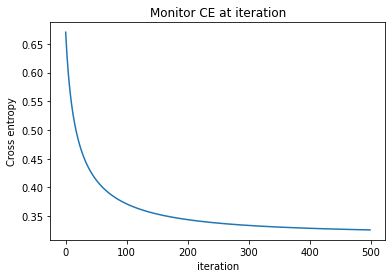

In [ ]:
logitreg = LogisticRegression(learning_rate = 0.05, max_iters=500)
loss = logitreg.monitor(imdb_x_train_top1000_nor, np.array(imdb_y_train_bi))[0]
fit = logitreg.monitor(imdb_x_train_top1000_nor, np.array(imdb_y_train_bi))[1]
print(fit.check_grad(imdb_x_train_top1000_nor, np.array(imdb_y_train_bi)))

plt.clf()
plt.plot(loss)
plt.title('Monitor CE at iteration')
plt.ylabel("Cross entropy")
plt.xlabel("iteration")
plt.show()

**2.1.2 20-new-groups**

In [ ]:
D = X_train.shape[1]
C = y_train.shape[1]

mlr = Multinomial_logistic(D, C)

In [ ]:
# check grad
random.seed(1234)
print(mlr.check_grad(X_train, y_train))

8.330859373537521e-15


iter 0: 6331.098; 1419.595
iter 1: 5350.068; 1248.066
iter 2: 4649.471; 1110.442
iter 3: 4063.431; 1028.126
iter 4: 3624.979; 922.301
iter 5: 3317.509; 874.960
iter 6: 3080.101; 806.255
iter 7: 2902.230; 774.098
iter 8: 2744.992; 731.065
iter 9: 2628.710; 709.000
iter 10: 2509.287; 676.821
iter 11: 2416.956; 657.034
iter 12: 2323.454; 629.398
iter 13: 2245.387; 616.560
iter 14: 2169.226; 593.268
iter 15: 2104.712; 577.118
iter 16: 2044.384; 563.223
iter 17: 1989.845; 549.761
iter 18: 1939.369; 538.614
iter 19: 1893.212; 527.579
iter 20: 1852.127; 517.788
iter 21: 1814.495; 508.279
iter 22: 1779.280; 499.710
iter 23: 1746.393; 491.310
iter 24: 1715.211; 483.766
iter 25: 1686.298; 476.347
iter 26: 1658.164; 469.622
iter 27: 1632.605; 463.076
iter 28: 1606.888; 456.970
iter 29: 1584.158; 451.180
iter 30: 1561.051; 445.611
iter 31: 1541.385; 440.593
iter 32: 1521.980; 435.555
iter 33: 1505.949; 431.443
iter 34: 1488.381; 426.687
iter 35: 1472.883; 422.932
iter 36: 1455.145; 418.265
iter 37

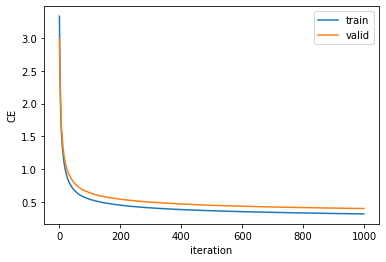

In [ ]:
ce_train, ce_valid = mlr.fit(X_train, y_train, X_valid, y_valid,lr=0.0001,niter=1000)

plt.clf()
plt.plot(ce_train/X_train.shape[0], label='train')
plt.plot(ce_valid/X_valid.shape[0], label='valid')
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
# plt.show()
plt.savefig("training_ce.png", bbox_inches="tight", dpi=300)

# **Task 3: Run experiments**

## **3.1. IMDB Reviews**

 ### **3.1.1 Logistic Regression and KNN**

In [ ]:
# Use top 1000 features
logitreg = LogisticRegression(learning_rate = 0.05, max_iters=500)
fit, w = logitreg.fit(imdb_x_train_top1000_nor, imdb_y_train_bi)


pred_train = fit.predict(imdb_x_train_top1000_nor)
pred_train_bi = (pred_train > 0.5).astype(int)
pred_test = fit.predict(imdb_x_test_top1000_nor)
pred_test_bi = (pred_test > 0.5).astype(int)

# accuracy = correctly classified / total classified
acc_train = sum(pred_train_bi==imdb_y_train_bi)/len(imdb_y_train_bi)
acc_test = sum(pred_test_bi==imdb_y_test_bi)/len(imdb_y_test_bi)
print(f"train accuracy (1000 features): {acc_train:.3f}; test accuracy (1000 features): {acc_test:.3f}")

train accuracy (1000 features): 0.868; test accuracy (1000 features): 0.848


In [ ]:
# Use top 500 featuers
# logitreg = LogisticRegression(learning_rate = 0.05, max_iters=500)
fit, w = logitreg.fit(imdb_x_train_top500_nor, imdb_y_train_bi)

pred_train = fit.predict(imdb_x_train_top500_nor)
pred_train_bi = (pred_train > 0.5).astype(int)
pred_test = fit.predict(imdb_x_test_top500_nor)
pred_test_bi = (pred_test > 0.5).astype(int)

# train/test acc
acc_train = sum(pred_train_bi==imdb_y_train_bi)/len(imdb_y_train_bi)
acc_test = sum(pred_test_bi==imdb_y_test_bi)/len(imdb_y_test_bi)
print(f"train accuracy (500 features): {acc_train:.3f}; test accuracy (500 features): {acc_test:.3f}")

train accuracy (500 features): 0.834; test accuracy (500 features): 0.818


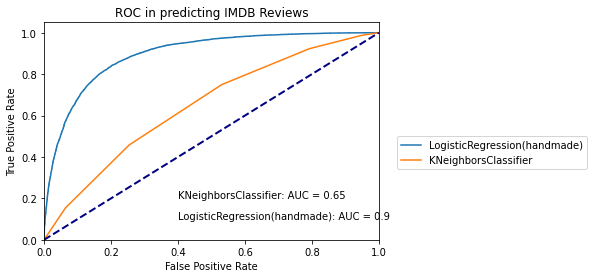

In [ ]:
# plot ROC
perf = {}

# our handmade LogisticRegression
#pred_test_prob = logitreg.fit(imdb_x_train_top1000, imdb_y_train_bi).predict(imdb_x_test_1000_nor)
fpr_lo, tpr_lo, _ = roc_curve(imdb_y_test_bi, pred_test)
auroc_lo = roc_auc_score(imdb_y_test_bi, pred_test)
perf["LogisticRegression(handmade)"] = {'fpr':fpr_lo, 'tpr':tpr_lo, 'auroc':auroc_lo}

# KNN
fit_knn = KNeighborsClassifier().fit(imdb_x_train_top1000,imdb_y_train_bi)
y_test_prob_knn = fit_knn.predict_proba(imdb_x_test_top1000)[:,1]
fpr_knn, tpr_knn, _ = roc_curve(imdb_y_test_bi, y_test_prob_knn)
auroc_knn = roc_auc_score(imdb_y_test_bi, y_test_prob_knn)
perf["KNeighborsClassifier"] = {'fpr':fpr_knn,'tpr':tpr_knn,'auroc':auroc_knn}

plt.clf()
i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],label=model_name)
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting IMDB Reviews')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")

###**3.1.2 Top 10 Positive/Negative Features**

In [ ]:
vocab = pd.read_csv('aclImdb/imdb.vocab', header=None)
label_train_x_word = label_train_x.rename(columns = vocab[0])
label_train_x_word_clean = label_train_x_word.iloc[:, np.where(np.logical_and(pro_train>0.01, pro_train<0.5))[0]]
words = label_train_x_word_clean.columns

**Simple Linear Regression and Z-scores**

In [ ]:
zscore_rank = imdb_zscore.argsort(axis=0).flatten()
top_10_pos_index = zscore_rank[-10:]
top_10_neg_index = zscore_rank[:10]
print("Top 10 Positive Words: ", words[top_10_pos_index])
print("Top 10 negative Words: ", words[top_10_neg_index])

Top 10 Positive Words:  Index(['favorite', 'loved', 'amazing', 'beautiful', 'perfect', 'love', 'best',
       'wonderful', 'excellent', 'great'],
      dtype='object')
Top 10 negative Words:  Index(['bad', 'worst', 'waste', 'awful', '?', 'no', 'worse', 'terrible',
       'boring', 'stupid'],
      dtype='object')


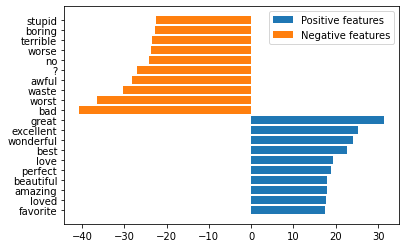

In [ ]:
top_pos = words[top_10_pos_index]
top_neg = words[top_10_neg_index]
plt.barh(top_pos, imdb_zscore[top_10_pos_index], label="Positive features")
plt.barh(top_neg, imdb_zscore[top_10_neg_index], label="Negative features")
plt.legend()

**Logistic Regression and Coefficients**

Top 10 Positive Words:  Index(['moves', 'rest', 'flicks', 'david', 'fail', 'anyone', 'songs', 'year',
       'successful', 'loves'],
      dtype='object')
Top 10 negative Words:  Index(['offers', 'collection', 'deserve', 'rarely', 'too', 'continues', 'real',
       'jr', 'lose', 'match'],
      dtype='object')


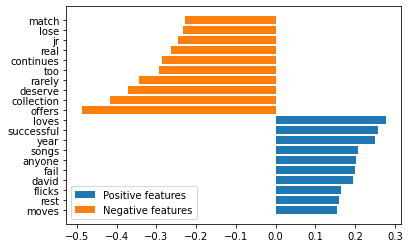

In [ ]:
words_lr = label_train_x_word_clean.iloc[:, imdb_top_zscore_index_1000]
effect_size = fit.w
coe_rank = effect_size.argsort()
top_10_pos_w = coe_rank[-10:]
top_10_neg_w = coe_rank[:10]

print("Top 10 Positive Words: ", words_lr.columns[top_10_pos_w])
print("Top 10 negative Words: ", words_lr.columns[top_10_neg_w])

plt.barh(words_lr.columns[top_10_pos_w], effect_size[top_10_pos_w], label="Positive features")
plt.barh(words_lr.columns[top_10_neg_w], effect_size[top_10_neg_w], label="Negative features")
plt.legend()

### **3.1.3 Altering training set size**

random 0.2: LogisticR auroc 0.823, KNN auroc 0.564
random 0.4: LogisticR auroc 0.839, KNN auroc 0.615
random 0.6: LogisticR auroc 0.844, KNN auroc 0.628
random 0.8: LogisticR auroc 0.846, KNN auroc 0.636


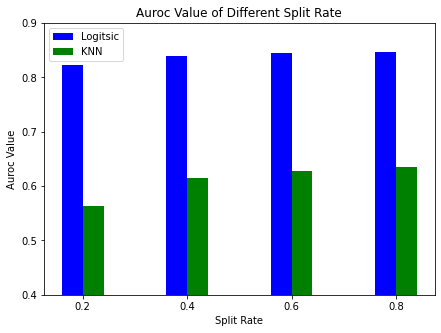

In [ ]:
split = [0.2, 0.4, 0.6, 0.8]
auroc_lo_all = []
auroc_knn_all = []

i = 0
while i < len(split):
    res = RandLogist(imdb_x_train_top1000_nor,imdb_y_train_bi,imdb_x_test_top1000_nor,imdb_y_test_bi,split[i])
    auroc_lo_all.append(res[0])
    auroc_knn_all.append(res[1])  
    print(f"random {split[i]}: LogisticR auroc {res[0]}, KNN auroc {res[1]}")
    i += 1

fig = plt.figure(figsize = (7, 5))
x = np.arange(4)

plt.ylim([0.4,0.9])
plt.bar(x-0.1, auroc_lo_all, color ='blue', width = 0.2)
plt.bar(x+0.1, auroc_knn_all, color = 'green', width = 0.2)
plt.xticks(x, split)
plt.xlabel("Split Rate")
plt.ylabel("Auroc Value")
plt.title("Auroc Value of Different Split Rate")
plt.legend(["Logitsic", "KNN"])
plt.show()

###**3.1.4 Adding Penalty**

In [ ]:
# Linear Regression Model
Linreg = LinearRegression().fit(imdb_x_train_top1000_nor, imdb_y_test_bi)
pred_lin = Linreg.predict(imdb_x_test_top1000_nor)
pred_lin = (pred_lin > 0.5).astype(int)
accuracy_lin = metrics.accuracy_score(imdb_y_test_bi, pred_lin)
accuracy_lin
# lower than LogisticRegression

0.83852

In [ ]:
# Ridge Regression
imdb_score_R = sk_LogisticRegression(penalty='l2', solver='liblinear', max_iter=1e3).fit(imdb_x_train_top1000, imdb_y_train_bi)

# LASSO
imdb_score_L = sk_LogisticRegression(penalty='l1', solver='liblinear', max_iter=1e3).fit(imdb_x_train_top1000, imdb_y_train_bi)

print("Ridge Regression")
print("Training acc: ", imdb_score_R.score(imdb_x_train_top1000, imdb_y_train_bi), "Testing acc: ", imdb_score_R.score(imdb_x_test_top1000, imdb_y_test_bi))
print("LASSO")
print("Training acc: ", imdb_score_L.score(imdb_x_train_top1000, imdb_y_train_bi), "Testing acc: ", imdb_score_L.score(imdb_x_test_top1000, imdb_y_test_bi))

Ridge Regression
Training acc:  0.86716 Testing acc:  0.84524
LASSO
Training acc:  0.8672 Testing acc:  0.84592


###**3.1.5 Optimizing with Learning Rate and Max Iteration**

In [ ]:
lr = [0.01, 0.05, 0.08, 0.1]
max_iter = [100, 500, 800, 1000]

for i in lr:
  for j in max_iter:
    logit_lr_i = LogisticRegression(learning_rate = i, max_iters = j)
    fit_lr_i, w_lr_i = logit_lr_i.fit(imdb_x_train_top1000_nor, imdb_y_train_bi)
    test_lr_i = (fit_lr_i.predict(imdb_x_test_top1000_nor) > 0.5).astype(int)
    acc_test_lr_i = sum(test_lr_i==imdb_y_test_bi)/len(imdb_y_test_bi)
    print("lr:", i, " Max Iteration:", j, " Test Accuracy:", acc_test_lr_i)


lr: 0.01  Max Iteration: 100  Test Accuracy: 0.83356
lr: 0.01  Max Iteration: 500  Test Accuracy: 0.84792
lr: 0.01  Max Iteration: 800  Test Accuracy: 0.84836
lr: 0.01  Max Iteration: 1000  Test Accuracy: 0.84836
lr: 0.05  Max Iteration: 100  Test Accuracy: 0.84796
lr: 0.05  Max Iteration: 500  Test Accuracy: 0.84808
lr: 0.05  Max Iteration: 800  Test Accuracy: 0.84564
lr: 0.05  Max Iteration: 1000  Test Accuracy: 0.84552
lr: 0.08  Max Iteration: 100  Test Accuracy: 0.84836
lr: 0.08  Max Iteration: 500  Test Accuracy: 0.8456
lr: 0.08  Max Iteration: 800  Test Accuracy: 0.84484
lr: 0.08  Max Iteration: 1000  Test Accuracy: 0.84492
lr: 0.1  Max Iteration: 100  Test Accuracy: 0.84836
lr: 0.1  Max Iteration: 500  Test Accuracy: 0.84552
lr: 0.1  Max Iteration: 800  Test Accuracy: 0.84492
lr: 0.1  Max Iteration: 1000  Test Accuracy: 0.84496


## **3.2. 20-news-groups**

###**3.2.1 Multiclass Regression**###

In [ ]:
def evaluate(y, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
    accuracy = accuracy / y.shape[0]
    return accuracy

In [ ]:
train_accuracy = evaluate(mlr.predict(X_train), y_train)
valid_accuracy = evaluate(mlr.predict(X_valid), y_valid)
test_accuracy = evaluate(mlr.predict(X_test), y_test)

print("Training acc: ", train_accuracy)
print("Validation acc: ", valid_accuracy)
print("Testing acc: ", test_accuracy)

Training acc:  0.8900578642819569
Validation acc:  0.8466386554621849
Testing acc:  0.7958280657395702


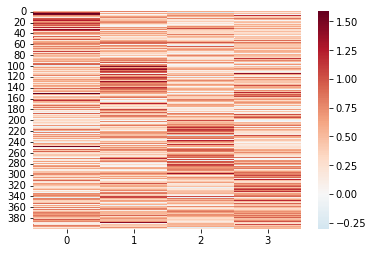

In [ ]:
from seaborn import heatmap
W_hat = mlr.W
hmp = heatmap(W_hat, cmap='RdBu_r', center=0)
fig = hmp.get_figure()
fig.savefig("W_hat.png")

In [ ]:
W_hat_transformed = np.exp(W_hat)
W_hat_transformed = W_hat_transformed / W_hat_transformed.sum(axis=0)[None,:]
W_hat_transformed

array([[0.00291946, 0.00121649, 0.00186946, 0.00113638],
       [0.00253117, 0.00305332, 0.00268064, 0.00241744],
       [0.00210089, 0.00215158, 0.00170692, 0.00278584],
       ...,
       [0.00171928, 0.00178256, 0.00285809, 0.00193685],
       [0.00173078, 0.00285528, 0.00122432, 0.00235559],
       [0.00224898, 0.00177779, 0.00180236, 0.00248749]], dtype=float128)

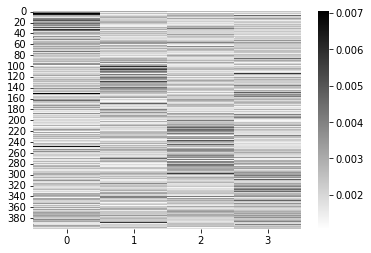

In [ ]:
hmp = heatmap(W_hat_transformed, cmap='gray_r')
fig = hmp.get_figure()
fig.savefig("W_hat_transformed.png")

###**3.2.2 KNN-20 news groups**###

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

k_range = list(range(1, 35))
param_grid = dict(n_neighbors=k_range)

# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=True,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train_tf, ng_train_y)

#knn = KNeighborsClassifier(n_neighbors=3)
#for k in k_range:
  #print(k,grid_search.best_score_)

print("Training Set")
print(grid_search.best_params_)
accuracy = grid_search.best_score_ *100
print("Train Accuracy of KNN: ", accuracy)#all train

print()
print("Testing Set")
grid_search2=grid.fit(X_test_tf, ng_test_y)
print(grid_search2.best_params_)
accuracy2 = grid_search2.best_score_ *100
print("Test Accuracy of KNN: ", accuracy2)#all test

Fitting 10 folds for each of 34 candidates, totalling 340 fits
Training Set
{'n_neighbors': 8}
Train Accuracy of KNN:  52.751834911179664

Testing Set
Fitting 10 folds for each of 34 candidates, totalling 340 fits
{'n_neighbors': 1}
Test Accuracy of KNN:  48.9300214951039


In [ ]:
grid_search3=grid.fit(X_train, y_train)
print(grid_search3.best_params_)
accuracy3 = grid_search3.best_score_ *100
print(accuracy3)#filtered train

Fitting 10 folds for each of 34 candidates, totalling 340 fits
{'n_neighbors': 1}
51.65941030586939


In [ ]:
grid_search4=grid.fit(X_test, y_test)
print(grid_search4.best_params_)
accuracy4 = grid_search4.best_score_ *100
print(accuracy4)#filtered test

Fitting 10 folds for each of 34 candidates, totalling 340 fits
{'n_neighbors': 1}
49.242894673990925


### **3.2.3 Altering training set size**###

In [ ]:
from typing import ValuesView
from sklearn import model_selection
def RandMulti(X_train, y_train, x_test, y_test, split_rate):
    X_train=X_train.values
    X_train = np.array(X_train, dtype=np.float128)

    X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_train, y_train, train_size = split_rate, random_state=1, shuffle=True)

    D = X_train.shape[1]
    C = y_train.shape[1]
    mlr = Multinomial_logistic(D, C)  

    # multiclass regression
    #mlr = Multinomial_logistic.fit(X_train, y_train)
    ce_train, ce_valid = mlr.fit(X_train, y_train, X_valid, y_valid,lr=0.0001,niter=1000)
    acc_mlr = evaluate(mlr.predict(X_test), y_test)

    # knn
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)
    acc_knn=knn.score(X_test, y_test)  
    
    print(acc_mlr, acc_knn)
    return acc_mlr, acc_knn

In [ ]:
acc_mlr_train20,acc_knn_train20 = RandMulti(X_train_pd, ng_train_y_encoded, X_test, y_test,0.2)

iter 0: 2559.372; 10034.372
iter 1: 2306.203; 9264.878
iter 2: 2112.189; 8645.065
iter 3: 1948.583; 8145.734
iter 4: 1819.470; 7721.446
iter 5: 1698.692; 7351.951
iter 6: 1583.799; 6997.884
iter 7: 1476.079; 6677.486
iter 8: 1375.640; 6362.773
iter 9: 1281.811; 6082.427
iter 10: 1196.030; 5801.187
iter 11: 1123.011; 5591.100
iter 12: 1060.001; 5391.134
iter 13: 1016.223; 5215.327
iter 14: 980.243; 5056.585
iter 15: 947.372; 4915.701
iter 16: 917.127; 4788.009
iter 17: 891.070; 4672.348
iter 18: 867.593; 4567.768
iter 19: 845.479; 4472.693
iter 20: 824.459; 4387.281
iter 21: 804.346; 4311.517
iter 22: 785.054; 4244.099
iter 23: 766.603; 4181.168
iter 24: 749.151; 4121.040
iter 25: 732.920; 4062.578
iter 26: 717.824; 4005.311
iter 27: 703.531; 3950.272
iter 28: 689.837; 3898.083
iter 29: 676.634; 3848.632
iter 30: 663.868; 3801.661
iter 31: 651.508; 3756.938
iter 32: 639.550; 3714.283
iter 33: 628.013; 3673.562
iter 34: 616.962; 3634.714
iter 35: 606.534; 3597.774
iter 36: 596.851; 3562.

In [ ]:
acc_mlr_train40,acc_knn_train40 = RandMulti(X_train_pd, ng_train_y_encoded,X_test, y_test,0.4)

iter 0: 3701.513; 5449.519
iter 1: 3090.752; 4593.572
iter 2: 2761.456; 4176.108
iter 3: 2478.573; 3822.006
iter 4: 2239.234; 3510.559
iter 5: 2073.511; 3257.651
iter 6: 1941.754; 3036.476
iter 7: 1831.308; 2873.137
iter 8: 1733.692; 2729.973
iter 9: 1646.750; 2607.333
iter 10: 1569.612; 2498.221
iter 11: 1501.438; 2404.668
iter 12: 1441.824; 2321.432
iter 13: 1389.003; 2243.468
iter 14: 1341.580; 2178.826
iter 15: 1299.943; 2121.831
iter 16: 1263.176; 2071.606
iter 17: 1229.865; 2026.273
iter 18: 1199.496; 1984.777
iter 19: 1171.627; 1946.362
iter 20: 1145.871; 1910.461
iter 21: 1121.926; 1876.627
iter 22: 1099.549; 1844.669
iter 23: 1078.542; 1814.650
iter 24: 1058.744; 1786.472
iter 25: 1040.018; 1760.000
iter 26: 1022.245; 1735.065
iter 27: 1005.327; 1711.560
iter 28: 989.181; 1689.383
iter 29: 973.745; 1668.500
iter 30: 958.966; 1648.815
iter 31: 944.809; 1630.281
iter 32: 931.348; 1612.753
iter 33: 919.152; 1596.304
iter 34: 908.563; 1581.067
iter 35: 898.768; 1566.887
iter 36: 8

In [ ]:
acc_mlr_train60,acc_knn_train60 = RandMulti(X_train_pd, ng_train_y_encoded,X_test, y_test,0.6)

iter 0: 5447.585; 3290.360
iter 1: 4236.113; 2669.196
iter 2: 3518.183; 2259.942
iter 3: 3077.973; 2061.627
iter 4: 2824.185; 1900.494
iter 5: 2714.905; 1824.488
iter 6: 2644.380; 1795.053
iter 7: 2334.158; 1590.175
iter 8: 2175.630; 1535.965
iter 9: 2083.083; 1452.323
iter 10: 2084.668; 1418.694
iter 11: 1865.570; 1336.020
iter 12: 1813.712; 1297.259
iter 13: 1765.799; 1284.770
iter 14: 1747.602; 1251.884
iter 15: 1669.806; 1236.895
iter 16: 1619.312; 1200.718
iter 17: 1583.326; 1191.743
iter 18: 1542.625; 1164.024
iter 19: 1507.938; 1152.301
iter 20: 1476.408; 1133.020
iter 21: 1447.661; 1122.012
iter 22: 1420.403; 1106.170
iter 23: 1395.226; 1095.515
iter 24: 1371.480; 1081.968
iter 25: 1349.264; 1071.928
iter 26: 1328.388; 1059.727
iter 27: 1309.123; 1050.755
iter 28: 1291.831; 1039.194
iter 29: 1276.893; 1032.068
iter 30: 1262.584; 1020.880
iter 31: 1248.260; 1014.774
iter 32: 1233.934; 1003.614
iter 33: 1220.483; 997.868
iter 34: 1207.366; 987.511
iter 35: 1195.040; 982.057
iter 

In [ ]:
acc_mlr_train80,acc_knn_train80 = RandMulti(X_train_pd, ng_train_y_encoded,X_test, y_test,0.8)

iter 0: 8111.929; 1945.983
iter 1: 6448.531; 1705.328
iter 2: 5792.559; 1534.439
iter 3: 4813.483; 1300.261
iter 4: 4412.678; 1198.399
iter 5: 3815.876; 1063.299
iter 6: 3553.777; 1011.009
iter 7: 3082.223; 899.835
iter 8: 2943.830; 863.191
iter 9: 2710.974; 814.867
iter 10: 2619.276; 783.388
iter 11: 2485.627; 753.964
iter 12: 2403.119; 727.745
iter 13: 2299.699; 703.142
iter 14: 2233.307; 682.063
iter 15: 2159.243; 663.048
iter 16: 2104.472; 645.764
iter 17: 2040.173; 629.373
iter 18: 1992.382; 615.263
iter 19: 1943.894; 601.845
iter 20: 1903.031; 590.151
iter 21: 1862.365; 578.598
iter 22: 1827.365; 568.521
iter 23: 1794.015; 558.536
iter 24: 1763.147; 549.580
iter 25: 1733.966; 540.450
iter 26: 1706.345; 532.502
iter 27: 1680.336; 524.095
iter 28: 1655.548; 516.968
iter 29: 1632.171; 509.273
iter 30: 1609.893; 502.782
iter 31: 1588.806; 495.784
iter 32: 1568.733; 489.804
iter 33: 1549.671; 483.456
iter 34: 1531.509; 477.907
iter 35: 1514.192; 472.147
iter 36: 1497.639; 466.978
iter

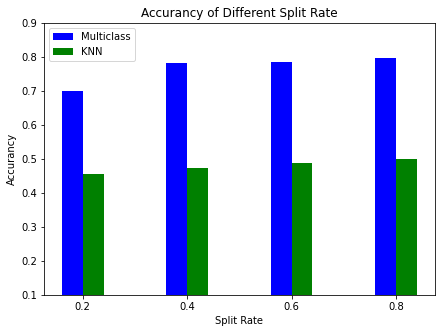

In [ ]:
split = [0.2, 0.4, 0.6, 0.8]
acc_mlr_all = [acc_mlr_train20, acc_mlr_train40, acc_mlr_train60, acc_mlr_train80]
acc_knn_all = [acc_knn_train20, acc_knn_train40, acc_knn_train60, acc_knn_train80]

#i = 0
#while i < len(split):
    #res = RandMulti(X_train_pd, ng_train_y_encoded,X_test, y_test,split[i])    
    #acc_mlr_all.append(res[0])    
    #acc_knn_all.append(res[1])    
    #print(f"random {split[i]}: Multiclass test acc {res[0]}, KNN test acc {res[1]}")
    #i += 1

fig = plt.figure(figsize = (7, 5))
x = np.arange(4)

plt.ylim([0.1,0.9])
plt.bar(x-0.1, acc_mlr_all, color ='blue', width = 0.2)
plt.bar(x+0.1, acc_knn_all, color = 'green', width = 0.2)
plt.xticks(x, split)
plt.xlabel("Split Rate")
plt.ylabel("Accurancy")
plt.title("Accurancy of Different Split Rate")
plt.legend(["Multiclass", "KNN"])
plt.show()

###**3.2.4 Top Positive Features**###

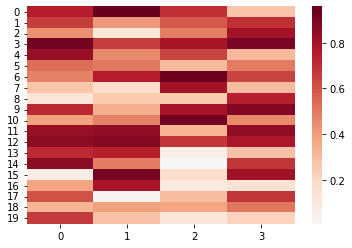

In [ ]:
from seaborn import heatmap
a1=x_sort_index1[:5]
b1=x_sort_index2[:5]
c1=x_sort_index3[:5]
d1=x_sort_index4[:5]
#print(a1)
X111=pd.DataFrame(ng_train_x).iloc[:,a1]
X222=pd.DataFrame(ng_train_x).iloc[:,b1]
X333=pd.DataFrame(ng_train_x).iloc[:,c1]
X444=pd.DataFrame(ng_train_x).iloc[:,d1]
X_top20=pd.concat([X111,X222,X333,X444], axis = 1, ignore_index = True, join = "outer")
#print(X_top20)
X_top20_np=X_top20.values
X_top20_np

D_1 = X_top20_np.shape[1]
C_1 = y_train.shape[1]

mlr_1 = Multinomial_logistic(D_1, C_1)
W_hat = mlr_1.W
hmp = heatmap(W_hat, cmap='RdBu_r', center=0)
fig = hmp.get_figure()
fig.savefig("W_hat.png")

###**3.2.5 Adding Penalty**###

In [ ]:
# Ridge Regression
ng_score_R = sk_LogisticRegression(penalty='l2', solver='saga', multi_class='multinomial', max_iter=1e3).fit(ng_train_x, ng_train_y)

# LASSO
ng_score_L = sk_LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=1e3).fit(ng_train_x, ng_train_y)

print("Ridge Regression")
print("Training acc: ", ng_score_R.score(ng_train_x, ng_train_y), "Testing acc: ", ng_score_R.score(ng_test_x, ng_test_y))
print("LASSO")
print("Training acc: ", ng_score_L.score(ng_train_x, ng_train_y), "Testing acc: ", ng_score_L.score(ng_test_x, ng_test_y))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Ridge Regression
Training acc:  0.9150189314261674 Testing acc:  0.8236409608091024
LASSO
Training acc:  0.9091291543962978 Testing acc:  0.8211125158027813


###**3.2.6 Using Adam optimizer**###

Learning rate is one of the most significant hyperparameters. Thus, to alleviate the negative impact of the inappropriate learning rate, we tried Adam optimization algorithm for gradient descent in multiclass regression. However, it turns out that Adam could not decrease the cross entropy, but instead it kept increasing from the beginning. To deal with this problem, We tried to decay the learning rate and increase the batch size separately according to Smith's research(2018), but the problem did not solve. Therefore, we speculate there may be a problem with Adam's code which leads it missed the optima.

Reference: Samuel L. Smith, Pieter-Jan Kindermans, Chris Ying, & Quoc V. Le. (2018). Don’t decay the learning rate, increase the batch size. International Conference on Learning Representations.

In [ ]:
# With Adam
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def predict(self, X):
        y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    # modify it to add stopping criteria
    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.005, niter=100,b1=0.9, b2=0.999):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in range(niter):
            #self.W = self.W - lr * self.grad(X, y)
            grad=self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train

            step_size=0.001
            eps=10**-8
            #eps=1e-3
            mhat,vhat=self.adam(losses_train[i].flatten(),grad.flatten(),self.W.flatten(),b1, b2)
            tmp_w=self.W.flatten()
            tmp_w = tmp_w - (step_size * mhat) / (np.sqrt(vhat) + eps)
            self.W=tmp_w.reshape(400,4)

            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            else:
                print(f"iter {i}: {loss_train:.3f}")
        return losses_train, losses_valid

    def adam(loss_value,grad, x, itr, b1=0.9, b2=0.999):
        m, v = (np.zeros(len(x)), np.zeros(len(x)))
        val= loss_value
        g = grad
        m = (1 - b1) * g      + b1 * m    # First  moment estimate.
        v = (1 - b2) * (g**2) + b2 * v    # Second moment estimate.
        mhat = m / (1 - b1**(itr + 1))    # Bias correction.
        vhat = v / (1 - b2**(itr + 1))
        # print(mhat)
        # print(vhat)
        return mhat,vhat


In [ ]:
#D = X_train.shape[1]
#C = y_train.shape[1]

#mlr = Multinomial_logistic(D, C)

In [ ]:
#ce_train, ce_valid = mlr.fit(X_train, y_train, X_valid, y_valid,lr=0.0005,niter=500)

#plt.clf()
#plt.plot(ce_train/X_train.shape[0], label='train')
#plt.plot(ce_valid/X_valid.shape[0], label='valid')
#plt.xlabel("iteration")
#plt.ylabel("CE")
#plt.legend()
#plt.show()
#plt.savefig("training_ce.png", bbox_inches="tight", dpi=300)